In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
from importlib import reload

%matplotlib inline

In [13]:
import cedar_videos
reload(cedar_videos)
from cedar_videos import *
measurement = "A2"

In [25]:
frame_offset = 100
vidcap = cv2.VideoCapture(os.path.join(data_dir, valid_measurement_videos[measurement]))
vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_offset)

success, image = vidcap.read()

[ 34.72727273  -8.81818182]


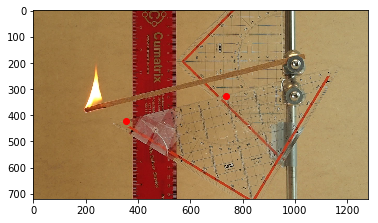

In [26]:
anchor_points = np.array([
    [355, 422],
    [737, 325]
])

anchor_distance = 11

plt.imshow(image[:,:,::-1])
plt.scatter(anchor_points[:,0], anchor_points[:,1], color='r')

anchor_vector = (anchor_points[1,:] - anchor_points[0,:]) / anchor_distance
anchor_length = np.linalg.norm(anchor_vector)
print(anchor_vector)
# plt.scatter(anchor_vector[0], anchor_vector[1])

plt.savefig("plots/raw_video_capture.jpg", dpi=300)

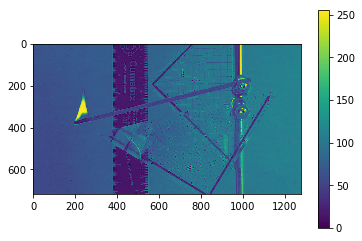

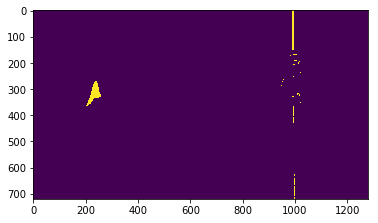

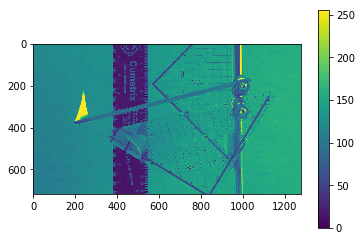

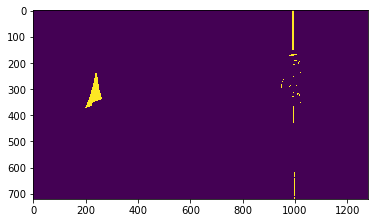

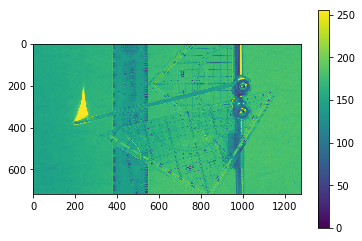

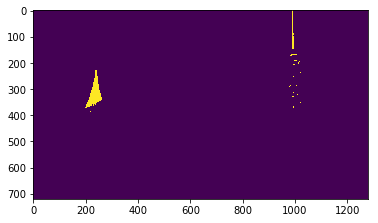

In [27]:
ths = [200, 210, 240]

for i in range(3):
    plt.imshow(image[:,:,i])
    plt.colorbar()
    plt.show()
    plt.imshow(image[:,:,i] > ths[i])
    plt.show()

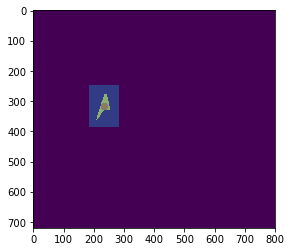

In [29]:
def get_thresholded_image(input_img):
    return (input_img[:,:,0] > ths[0]) & (input_img[:,:,1] > ths[1]) & (input_img[:,:,0] > ths[2])

def get_image_centroid_and_pixels(input_img):
    flame_pixels = input_img.sum()
    if flame_pixels > 0:
        return np.argwhere(input_img==1).sum(0)/flame_pixels, flame_pixels
    else:
        return None
    
def get_masked_image_centroid_and_pixels(input_img, mask_rect):
    x1, y1, x2, y2 = [int(v) for v in mask_rect]
    cropout_img = input_img[x1:x2, y1:y2]
    cropout_centroid, flame_pixels = get_image_centroid_and_pixels(cropout_img)
    centroid = cropout_centroid + mask_rect[0:2]
    return centroid, flame_pixels

def get_mask_rect(rect_center, rect_size):
    return np.append(rect_center - rect_size/2, rect_center + rect_size/2)

def get_flame_data_from_thr_image(input_img, max_x, flame_size = np.array([50, 50])):
    bare_data = get_image_centroid_and_pixels(input_img)
    if bare_data is not None:
        bare_center, _ = bare_data
        masked_center, flame_pixels = get_masked_image_centroid_and_pixels(input_img, get_mask_rect(bare_center, flame_size*2))
        return masked_center, flame_pixels
    else:
        return None
    
flame_size = np.array([70, 50])
    
max_x = 800

flame_thresholded_img = get_thresholded_image(image[:,:max_x,:])
plt.imshow(flame_thresholded_img)

center, _ = get_image_centroid_and_pixels(flame_thresholded_img)
plt.scatter(center[1], center[0])

ax = plt.gca()

ax.add_patch(Rectangle(center[::-1] - flame_size[::-1], 2*flame_size[1], 2*flame_size[0], alpha=0.5))

masked_center, pixels = get_flame_data_from_thr_image(flame_thresholded_img, max_x=800)
plt.scatter(masked_center[1], masked_center[0])

plt.savefig("plots/processed_video_capture.png", dpi=300)

In [96]:
frame_step = 10

vidcap = cv2.VideoCapture(os.path.join(data_dir, valid_measurement_videos[measurement]))
frames = int(np.round(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)))
fps    = np.round(vidcap.get(cv2.CAP_PROP_FPS))

frames = np.arange(0, frames, frame_step)
data_points = frames.size

flame_tracked_data = np.zeros((data_points, 5))

success = True
i = 0
for f in frames:
    print("Analysing frame %d ..." % f, end=' ')
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, f)
    success, image = vidcap.read()
    if success:
        flame_thresholded_img = get_thresholded_image(image[:,:max_x,:])
        # plt.imshow(flame_thresholded_img)

        flame_data = get_flame_data_from_thr_image(flame_thresholded_img, max_x=800, flame_rect_size=np.array([70,50]))
        if flame_data is not None:
            print("Flame detected")
            flame_center, flame_pixels = flame_data
            # plt.scatter(flame_center[1], flame_center[0])
            # plt.show()
            geo_coord = np.dot(anchor_vector, flame_center[::-1]) / anchor_length**2
            flame_tracked_data[i,:] = [f, flame_pixels, flame_center[1], flame_center[0], geo_coord]
            i += 1
        else:
            print("No flame detected")
            
flame_tracked_data = flame_tracked_data[:i,:]

Analysing frame 0 ... No flame detected
Analysing frame 10 ... No flame detected
Analysing frame 20 ... No flame detected
Analysing frame 30 ... No flame detected
Analysing frame 40 ... Flame detected
Analysing frame 50 ... No flame detected
Analysing frame 60 ... Flame detected
Analysing frame 70 ... Flame detected
Analysing frame 80 ... Flame detected
Analysing frame 90 ... Flame detected
Analysing frame 100 ... Flame detected
Analysing frame 110 ... Flame detected
Analysing frame 120 ... Flame detected
Analysing frame 130 ... Flame detected
Analysing frame 140 ... Flame detected
Analysing frame 150 ... Flame detected
Analysing frame 160 ... Flame detected
Analysing frame 170 ... Flame detected
Analysing frame 180 ... Flame detected
Analysing frame 190 ... Flame detected
Analysing frame 200 ... Flame detected
Analysing frame 210 ... Flame detected
Analysing frame 220 ... Flame detected
Analysing frame 230 ... Flame detected
Analysing frame 240 ... Flame detected
Analysing frame 250 .

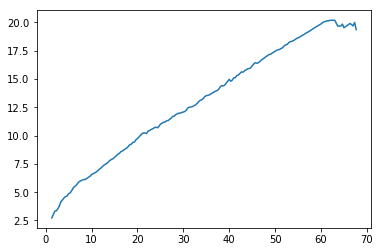

In [98]:
plt.plot(flame_tracked_data[:,0] / fps, flame_tracked_data[:,4])